# TSP Algorithm Comprehensive Comparison Analysis: Peking University Campus Path Planning

This notebook conducts a fair and systematic comparative analysis of six TSP solving algorithms:

1. **Random Path Algorithm** (Random Path - Baseline)
2. **Traditional Ant Colony Optimization** (Traditional ACO)
3. **Heterogeneous Ant Colony Optimization** (Heterogeneous ACO)  
4. **Genetic Algorithm** (Genetic Algorithm)
5. **Simulated Annealing Algorithm** (Simulated Annealing)
6. **Greedy Algorithm** (Greedy Algorithm)

## 📊 Comparison Dimensions
- **Solution Quality**: Shortest path distance, stability
- **Computational Efficiency**: Execution time, convergence speed
- **Algorithm Characteristics**: Parameter sensitivity, applicable scenarios
- **Baseline Comparison**: Improvement degree relative to random baseline
- **Statistical Analysis**: Statistical significance test of multiple runs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time
import math
import pandas as pd
import seaborn as sns
from copy import deepcopy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set English font
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

# Set random seed to ensure reproducible results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Matplotlib English display settings
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# Map file path
MAP_IMAGE_PATH = 'map_1.0.jpg'

# Peking University landmark coordinates
CITIES = {
    "West Gate": (703, 595),
    "Weiming Lake": (1069, 630), 
    "Jing Yuan": (928, 830),
    "Boya Tower": (1148, 646),
    "Statue of the Former Principal Cai Yuanpei": (885, 632),
    "Zhibeizi Garden": (1320, 1052),
    "YANNANYUAN": (969, 991),
    "May 4th Playground": (1251, 1147),
    "University Library": (1083, 816),
    "Stone Fish": (959, 632),
    "Tomb of Mr. Edgar Snow": (1070, 730),
    "Marble Boat": (1040, 571),
    "Luce Pavilion": (1012, 582),
    "Tian Yuan": (1314, 670),
    "MINGHE YUAN": (733, 518),
    "Campus Scenery Pavilion": (840, 470),
    "LANGRUN YUAN": (1134, 271),
    "JINGCHUN YUAN": (945, 455),
    "Lotus Pond": (750, 432),
    "SHAO HAI": (736, 742),
    "Catering Building": (939, 1111),
    "Humanities Garden": (1155, 433),
    "Statue of Professor Li Dazhao": (926, 738),
    "Museum of University History": (785,713),
    "University Hall": (1098, 992),
    "North Shore": (1049, 519),
    "The Bridge of Magpies": (993, 559),
    "Silent Wall": (1118, 503),
    "Fountain": (878, 1062),
    "Red Lake": (864, 419),
    "The Institute of Poetry Studies": (993, 358),
    "Tan Siu Lin Center for International Studies": (1080, 697)
}

# Convert to array format for easy calculation
city_names = list(CITIES.keys())
city_coords = np.array(list(CITIES.values()))
num_cities = len(CITIES)

print(f"Total number of Peking University campus landmarks: {num_cities}")
print(f"Test data scale: TSP problem with {num_cities} POIs")
print("="*80)

Total number of Peking University campus landmarks: 32
Test data scale: TSP problem with 32 POIs


## 🧮 Common Utility Functions Definition

In [3]:
def calculate_distance_matrix(coords):
    """Calculate Euclidean distance matrix between cities"""
    n = len(coords)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i][j] = np.sqrt((coords[i][0] - coords[j][0])**2 + 
                                        (coords[i][1] - coords[j][1])**2)
    return distances

def calculate_path_distance(path, distance_matrix):
    """Calculate total distance of given path"""
    total_distance = 0
    for i in range(len(path)):
        current_city = path[i]
        next_city = path[(i + 1) % len(path)]
        total_distance += distance_matrix[current_city][next_city]
    return total_distance

def plot_path(path, title, algorithm_name, distance):
    """Plot path visualization"""
    plt.figure(figsize=(12, 8))
    
    # Draw map background
    try:
        campus_map = mpimg.imread(MAP_IMAGE_PATH)
        plt.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
    except FileNotFoundError:
        print(f"Warning: Map file '{MAP_IMAGE_PATH}' not found")
        plt.xlim(0, 1500)
        plt.ylim(0, 1200)
        plt.gca().invert_yaxis()
    
    # Draw path
    path_coords = city_coords[path + [path[0]]]
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'r-', linewidth=3, alpha=0.8)
    
    # Draw city points
    plt.scatter(city_coords[:, 0], city_coords[:, 1], 
               c='blue', s=80, zorder=5, alpha=0.7, edgecolors='white', linewidth=1)
    
    # Highlight starting point
    start_coord = city_coords[path[0]]
    plt.scatter(start_coord[0], start_coord[1], c='green', s=150, marker='s', 
               zorder=6, edgecolors='white', linewidth=2)
    
    plt.title(f'{title}\n{algorithm_name} | Path Distance: {distance:.2f}', fontsize=14, fontweight='bold')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.tight_layout()
    return plt.gcf()

# Calculate distance matrix
distance_matrix = calculate_distance_matrix(city_coords)
print("Distance matrix calculation completed")
print(f"Distance matrix size: {distance_matrix.shape}")

Distance matrix calculation completed
Distance matrix size: (32, 32)


## 🐜 Traditional Ant Colony Optimization Algorithm Implementation

In [4]:
class TraditionalACO:
    def __init__(self, distance_matrix, n_ants=30, n_iterations=100, 
                 alpha=1.0, beta=2.0, rho=0.5, Q=100):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic factor importance
        self.rho = rho      # Pheromone evaporation coefficient
        self.Q = Q          # Pheromone intensity
        
        # Initialize pheromone matrix
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        
        # Heuristic information matrix (reciprocal of distance)
        self.eta = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:
                    self.eta[i][j] = 1.0 / self.distance_matrix[i][j]
    
    def select_next_city(self, current_city, unvisited):
        """Select next city based on probability"""
        if not unvisited:
            return None
            
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** self.alpha
            heuristic_val = self.eta[current_city][city] ** self.beta
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        # Roulette wheel selection
        rand = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                return unvisited[i]
        return unvisited[-1]
    
    def construct_solution(self, start_city=0):
        """Construct a solution"""
        path = [start_city]
        unvisited = list(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        while unvisited:
            next_city = self.select_next_city(current_city, unvisited)
            path.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
            
        return path
    
    def update_pheromone(self, all_paths, all_distances):
        """Update pheromone"""
        # Pheromone evaporation
        self.pheromone *= (1 - self.rho)
        
        # Add new pheromone
        for path, distance in zip(all_paths, all_distances):
            pheromone_to_add = self.Q / distance
            for i in range(len(path)):
                current_city = path[i]
                next_city = path[(i + 1) % len(path)]
                self.pheromone[current_city][next_city] += pheromone_to_add
                self.pheromone[next_city][current_city] += pheromone_to_add
    
    def solve(self, start_city=0, verbose=False):
        """Solve TSP"""
        best_path = None
        best_distance = float('inf')
        
        for iteration in range(self.n_iterations):
            # All ants construct solutions
            all_paths = []
            all_distances = []
            
            for ant in range(self.n_ants):
                path = self.construct_solution(start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # Update pheromone
            self.update_pheromone(all_paths, all_distances)
            
            if verbose and iteration % 20 == 0:
                print(f"Iteration {iteration}: Best distance = {best_distance:.2f}")
        
        return best_path, best_distance

print("Traditional Ant Colony Optimization algorithm implementation completed")

Traditional Ant Colony Optimization algorithm implementation completed


## 🐜🐜 Heterogeneous Ant Colony Optimization Algorithm Implementation

In [5]:
class HeterogeneousACO:
    def __init__(self, distance_matrix, n_scout_ants=15, n_forager_ants=15, 
                 n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.n_scout_ants = n_scout_ants
        self.n_forager_ants = n_forager_ants
        self.n_total_ants = n_scout_ants + n_forager_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        
        # Initialize pheromone matrix
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        
        # Heuristic information matrix
        self.eta = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:
                    self.eta[i][j] = 1.0 / self.distance_matrix[i][j]
        
        # Ant response thresholds (for role assignment)
        self.response_thresholds = np.random.uniform(0.3, 0.7, self.n_total_ants)
    
    def select_next_city_scout(self, current_city, unvisited):
        """Scout ant city selection strategy (more exploration)"""
        if not unvisited:
            return None
        
        # Scout ants rely more on heuristic information, less on pheromone
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** (self.alpha * 0.5)
            heuristic_val = self.eta[current_city][city] ** (self.beta * 1.5)
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        return np.random.choice(unvisited, p=probabilities)
    
    def select_next_city_forager(self, current_city, unvisited):
        """Forager ant city selection strategy (more exploitation)"""
        if not unvisited:
            return None
        
        # Forager ants rely more on pheromone information
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** (self.alpha * 1.5)
            heuristic_val = self.eta[current_city][city] ** (self.beta * 0.8)
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        return np.random.choice(unvisited, p=probabilities)
    
    def construct_solution(self, ant_type, start_city=0):
        """Construct solution based on ant type"""
        path = [start_city]
        unvisited = list(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        while unvisited:
            if ant_type == 'scout':
                next_city = self.select_next_city_scout(current_city, unvisited)
            else:  # forager
                next_city = self.select_next_city_forager(current_city, unvisited)
            
            path.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
            
        return path
    
    def update_pheromone(self, all_paths, all_distances):
        """Update pheromone"""
        # Pheromone evaporation
        self.pheromone *= (1 - self.rho)
        
        # Add new pheromone (better solutions get more pheromone)
        min_distance = min(all_distances)
        for path, distance in zip(all_paths, all_distances):
            # Shorter distance gets more pheromone increase
            pheromone_to_add = self.Q * (min_distance / distance) / distance
            for i in range(len(path)):
                current_city = path[i]
                next_city = path[(i + 1) % len(path)]
                self.pheromone[current_city][next_city] += pheromone_to_add
                self.pheromone[next_city][current_city] += pheromone_to_add
    
    def solve(self, start_city=0, verbose=False):
        """Solve TSP"""
        best_path = None
        best_distance = float('inf')
        
        for iteration in range(self.n_iterations):
            all_paths = []
            all_distances = []
            
            # Scout ants construct solutions
            for scout in range(self.n_scout_ants):
                path = self.construct_solution('scout', start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # Forager ants construct solutions
            for forager in range(self.n_forager_ants):
                path = self.construct_solution('forager', start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # Update pheromone
            self.update_pheromone(all_paths, all_distances)
            
            if verbose and iteration % 20 == 0:
                print(f"Iteration {iteration}: Best distance = {best_distance:.2f}")
        
        return best_path, best_distance

print("Heterogeneous Ant Colony Optimization algorithm implementation completed")

Heterogeneous Ant Colony Optimization algorithm implementation completed


## 🧬 Genetic Algorithm Implementation

In [6]:
class GeneticAlgorithm:
    def __init__(self, distance_matrix, population_size=100, generations=200, 
                 crossover_rate=0.8, mutation_rate=0.02, elite_size=20):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
    
    def calculate_fitness(self, individual):
        """Calculate individual fitness (reciprocal of distance)"""
        distance = calculate_path_distance(individual, self.distance_matrix)
        return 1 / distance
    
    def create_initial_population(self, start_city=0):
        """Create initial population"""
        population = []
        cities = list(range(self.n_cities))
        cities.remove(start_city)
        
        for _ in range(self.population_size):
            individual = [start_city] + random.sample(cities, len(cities))
            population.append(individual)
        
        return population
    
    def selection(self, population):
        """Roulette wheel selection"""
        fitness_scores = [self.calculate_fitness(ind) for ind in population]
        total_fitness = sum(fitness_scores)
        
        if total_fitness == 0:
            return random.choice(population)
        
        probabilities = [f / total_fitness for f in fitness_scores]
        return np.random.choice(len(population), p=probabilities)
    
    def order_crossover(self, parent1, parent2):
        """Order crossover (OX)"""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size), 2))  # Exclude starting point
        
        child = [None] * size
        child[0] = parent1[0]  # Keep starting point unchanged
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[1:end]:  # Skip starting point
            if city not in child:
                if pointer >= size:
                    pointer = 1  # Skip starting point
                child[pointer] = city
                pointer += 1
                if pointer == start:
                    pointer = end
        
        return child
    
    def mutate(self, individual):
        """Mutation operation (swap two non-starting cities)"""
        if random.random() < self.mutation_rate:
            if len(individual) > 3:  # At least 3 cities needed for swap
                idx1, idx2 = random.sample(range(1, len(individual)), 2)
                individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual
    
    def solve(self, start_city=0, verbose=False):
        """Solve TSP"""
        population = self.create_initial_population(start_city)
        
        best_distance = float('inf')
        best_path = None
        
        for generation in range(self.generations):
            # Calculate fitness and sort
            fitness_pairs = [(ind, self.calculate_fitness(ind)) for ind in population]
            fitness_pairs.sort(key=lambda x: x[1], reverse=True)
            
            # Update best solution
            current_best = fitness_pairs[0][0]
            current_distance = calculate_path_distance(current_best, self.distance_matrix)
            if current_distance < best_distance:
                best_distance = current_distance
                best_path = current_best.copy()
            
            # Elite preservation
            new_population = [ind for ind, _ in fitness_pairs[:self.elite_size]]
            
            # Generate new individuals
            while len(new_population) < self.population_size:
                if random.random() < self.crossover_rate:
                    parent1_idx = self.selection(population)
                    parent2_idx = self.selection(population)
                    child = self.order_crossover(population[parent1_idx], population[parent2_idx])
                else:
                    child = random.choice(population).copy()
                
                child = self.mutate(child)
                new_population.append(child)
            
            population = new_population
            
            if verbose and generation % 40 == 0:
                print(f"Generation {generation}: Best distance = {best_distance:.2f}")
        
        return best_path, best_distance

print("Genetic algorithm implementation completed")

Genetic algorithm implementation completed


## 🌡️ Simulated Annealing Algorithm Implementation

In [7]:
class SimulatedAnnealing:
    def __init__(self, distance_matrix, initial_temp=10000, final_temp=1, 
                 cooling_rate=0.995, max_iterations=10000):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
    
    def generate_initial_solution(self, start_city=0):
        """Generate initial solution"""
        cities = list(range(self.n_cities))
        cities.remove(start_city)
        random.shuffle(cities)
        return [start_city] + cities
    
    def generate_neighbor(self, solution):
        """Generate neighbor solution (2-opt swap)"""
        new_solution = solution.copy()
        if len(solution) > 3:
            i, j = sorted(random.sample(range(1, len(solution)), 2))
            new_solution[i:j+1] = reversed(new_solution[i:j+1])
        return new_solution
    
    def acceptance_probability(self, current_cost, new_cost, temperature):
        """Calculate acceptance probability"""
        if new_cost < current_cost:
            return 1.0
        if temperature <= 0:
            return 0.0
        return math.exp(-(new_cost - current_cost) / temperature)
    
    def solve(self, start_city=0, verbose=False):
        """Solve TSP"""
        current_solution = self.generate_initial_solution(start_city)
        current_cost = calculate_path_distance(current_solution, self.distance_matrix)
        
        best_solution = current_solution.copy()
        best_cost = current_cost
        
        temperature = self.initial_temp
        iteration = 0
        
        while temperature > self.final_temp and iteration < self.max_iterations:
            new_solution = self.generate_neighbor(current_solution)
            new_cost = calculate_path_distance(new_solution, self.distance_matrix)
            
            if random.random() < self.acceptance_probability(current_cost, new_cost, temperature):
                current_solution = new_solution
                current_cost = new_cost
                
                if current_cost < best_cost:
                    best_solution = current_solution.copy()
                    best_cost = current_cost
            
            temperature *= self.cooling_rate
            iteration += 1
            
            if verbose and iteration % 2000 == 0:
                print(f"Iteration {iteration}: Best distance = {best_cost:.2f}, Temperature = {temperature:.2f}")
        
        return best_solution, best_cost

print("Simulated annealing algorithm implementation completed")

Simulated annealing algorithm implementation completed


## 🏃 Greedy Algorithm Implementation

In [8]:
class GreedyAlgorithm:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
    
    def solve(self, start_city=0, verbose=False):
        """Solve TSP (nearest neighbor strategy)"""
        path = [start_city]
        unvisited = set(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        total_distance = 0
        
        while unvisited:
            # Find nearest unvisited city
            nearest_city = min(unvisited, 
                             key=lambda city: self.distance_matrix[current_city][city])
            
            total_distance += self.distance_matrix[current_city][nearest_city]
            path.append(nearest_city)
            unvisited.remove(nearest_city)
            current_city = nearest_city
        
        # Return to starting point
        total_distance += self.distance_matrix[current_city][start_city]
        
        if verbose:
            print(f"Greedy algorithm completed, total distance: {total_distance:.2f}")
        
        return path, total_distance

print("Greedy algorithm implementation completed")

Greedy algorithm implementation completed


## 🎲 Random Path Algorithm Implementation (Baseline)

In [9]:
class RandomPathAlgorithm:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
    
    def solve(self, start_city=0, verbose=False):
        """Randomly generate path as baseline"""
        # Create list of other cities excluding starting city
        other_cities = list(range(self.n_cities))
        other_cities.remove(start_city)
        
        # Randomly shuffle other cities
        random.shuffle(other_cities)
        
        # Construct complete path
        path = [start_city] + other_cities
        
        # Calculate path distance
        total_distance = calculate_path_distance(path, self.distance_matrix)
        
        if verbose:
            print(f"Random path algorithm completed, total distance: {total_distance:.2f}")
        
        return path, total_distance

print("Random path algorithm implementation completed (as Baseline)")

Random path algorithm implementation completed (as Baseline)


## 🥊 Algorithm Comparison Test

In [10]:
def run_algorithm_comparison(num_runs=10, start_city=0):
    """Run algorithm comparison test (including random baseline)"""
    
    algorithms = {
        'Random Path': RandomPathAlgorithm,
        'Greedy Algorithm': GreedyAlgorithm,
        'Simulated Annealing': SimulatedAnnealing,
        'Traditional ACO': TraditionalACO,
        'Genetic Algorithm': GeneticAlgorithm,
        'Heterogeneous ACO': HeterogeneousACO
    }
    
    # Unified parameter settings (fair comparison)
    algorithm_params = {
        'Random Path': {},
        'Greedy Algorithm': {},
        'Simulated Annealing': {'initial_temp': 10000, 'max_iterations': 10000},
        'Traditional ACO': {'n_ants': 30, 'n_iterations': 100},
        'Genetic Algorithm': {'population_size': 100, 'generations': 100},
        'Heterogeneous ACO': {'n_scout_ants': 15, 'n_forager_ants': 15, 'n_iterations': 100}
    }
    
    results = {}
    
    print("🚀 Starting algorithm comparison test (including random baseline)")
    print(f"Number of tests: {num_runs}")
    print(f"Starting city: {city_names[start_city]}")
    print("="*80)
    
    for alg_name, alg_class in algorithms.items():
        print(f"\n🔍 Testing algorithm: {alg_name}")
        
        distances = []
        times = []
        paths = []
        
        for run in range(num_runs):
            print(f"  Run {run+1}/{num_runs}...", end=" ")
            
            # Reset random seed to ensure fairness
            np.random.seed(RANDOM_SEED + run)
            random.seed(RANDOM_SEED + run)
            
            # Create algorithm instance
            params = algorithm_params[alg_name]
            if alg_name in ['Traditional ACO', 'Heterogeneous ACO', 'Genetic Algorithm', 'Simulated Annealing']:
                algorithm = alg_class(distance_matrix, **params)
            else:  # Greedy algorithm and random path
                algorithm = alg_class(distance_matrix)
            
            # Time the execution
            start_time = time.time()
            path, distance = algorithm.solve(start_city=start_city, verbose=False)
            end_time = time.time()
            
            execution_time = end_time - start_time
            distances.append(distance)
            times.append(execution_time)
            paths.append(path)
            
            print(f"Distance: {distance:.2f}, Time: {execution_time:.4f}s")
        
        # Calculate statistics
        results[alg_name] = {
            'distances': distances,
            'times': times,
            'paths': paths,
            'mean_distance': np.mean(distances),
            'std_distance': np.std(distances),
            'min_distance': np.min(distances),
            'max_distance': np.max(distances),
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'best_path': paths[np.argmin(distances)]
        }
        
        print(f"  Average distance: {results[alg_name]['mean_distance']:.2f} ± {results[alg_name]['std_distance']:.2f}")
        print(f"  Best distance: {results[alg_name]['min_distance']:.2f}")
        print(f"  Average time: {results[alg_name]['mean_time']:.4f}s")
    
    return results

# Run comparison test
comparison_results = run_algorithm_comparison(num_runs=10, start_city=0)

🚀 Starting algorithm comparison test (including random baseline)
Number of tests: 10
Starting city: West Gate

🔍 Testing algorithm: Random Path
  Run 1/10... Distance: 11690.92, Time: 0.0015s
  Run 2/10... Distance: 12915.39, Time: 0.0000s
  Run 3/10... Distance: 10437.32, Time: 0.0000s
  Run 4/10... Distance: 11484.15, Time: 0.0000s
  Run 5/10... Distance: 11013.67, Time: 0.0000s
  Run 6/10... Distance: 10979.58, Time: 0.0000s
  Run 7/10... Distance: 12310.39, Time: 0.0000s
  Run 8/10... Distance: 11872.04, Time: 0.0000s
  Run 9/10... Distance: 11807.55, Time: 0.0000s
  Run 10/10... Distance: 10051.54, Time: 0.0000s
  Average distance: 11456.26 ± 815.19
  Best distance: 10051.54
  Average time: 0.0002s

🔍 Testing algorithm: Greedy Algorithm
  Run 1/10... Distance: 3728.19, Time: 0.0001s
  Run 2/10... Distance: 3728.19, Time: 0.0001s
  Run 3/10... Distance: 3728.19, Time: 0.0001s
  Run 4/10... Distance: 3728.19, Time: 0.0001s
  Run 5/10... Distance: 3728.19, Time: 0.0003s
  Run 6/10...

## 📊 Results Statistical Analysis

In [11]:
# Create results summary table
def create_results_summary(results):
    """Create results summary table (including random baseline)"""
    summary_data = []
    
    for alg_name, data in results.items():
        summary_data.append({
            'Algorithm': alg_name,
            'Average Distance': data['mean_distance'],
            'Standard Deviation': data['std_distance'],
            'Best Distance': data['min_distance'],
            'Worst Distance': data['max_distance'],
            'Average Time(s)': data['mean_time'],
            'Time Std Dev': data['std_time']
        })
    
    df = pd.DataFrame(summary_data)
    df = df.sort_values('Average Distance')  # Sort by average distance
    
    return df

# Generate summary table
summary_df = create_results_summary(comparison_results)
print("📊 Algorithm Performance Summary Table (including random baseline)")
print("="*100)
print(summary_df.to_string(index=False, float_format='%.2f'))

# Calculate performance improvement percentage
print("\n📈 Relative Performance Analysis (using best algorithm as benchmark)")
print("="*80)

best_mean_distance = summary_df['Average Distance'].min()
best_algorithm = summary_df.loc[summary_df['Average Distance'].idxmin(), 'Algorithm']

print(f"Best algorithm: {best_algorithm} (Average distance: {best_mean_distance:.2f})")

# Special attention to random path performance
random_distance = comparison_results['Random Path']['mean_distance']
print(f"Random Baseline: Random Path (Average distance: {random_distance:.2f})")

print("\nRelative performance of each algorithm:")

for _, row in summary_df.iterrows():
    if row['Algorithm'] == best_algorithm:
        print(f"  {row['Algorithm']:<15}: Benchmark algorithm (0.0%)")
    else:
        improvement = (row['Average Distance'] - best_mean_distance) / best_mean_distance * 100
        print(f"  {row['Algorithm']:<15}: +{improvement:.1f}%")

print("\n🎯 Improvement relative to random baseline:")
print("-" * 50)

for _, row in summary_df.iterrows():
    if row['Algorithm'] == 'Random Path':
        print(f"  {row['Algorithm']:<15}: Baseline (0.0%)")
    else:
        improvement = (random_distance - row['Average Distance']) / random_distance * 100
        if improvement > 0:
            print(f"  {row['Algorithm']:<15}: Improvement {improvement:.1f}%")
        else:
            print(f"  {row['Algorithm']:<15}: Degradation {-improvement:.1f}%")

📊 Algorithm Performance Summary Table (including random baseline)
          Algorithm  Average Distance  Standard Deviation  Best Distance  Worst Distance  Average Time(s)  Time Std Dev
  Heterogeneous ACO           3664.75                1.30        3662.15         3665.40             1.91          0.08
    Traditional ACO           3665.40                0.00        3665.40         3665.40             0.88          0.01
   Greedy Algorithm           3728.19                0.00        3728.19         3728.19             0.00          0.00
Simulated Annealing           4029.72              140.47        3812.46         4339.84             0.02          0.00
  Genetic Algorithm           5462.26              263.56        4935.69         6006.07             7.88          0.06
        Random Path          11456.26              815.19       10051.54        12915.39             0.00          0.00

📈 Relative Performance Analysis (using best algorithm as benchmark)
Best algorithm: Heterogen

## 📈 Visualization Analysis

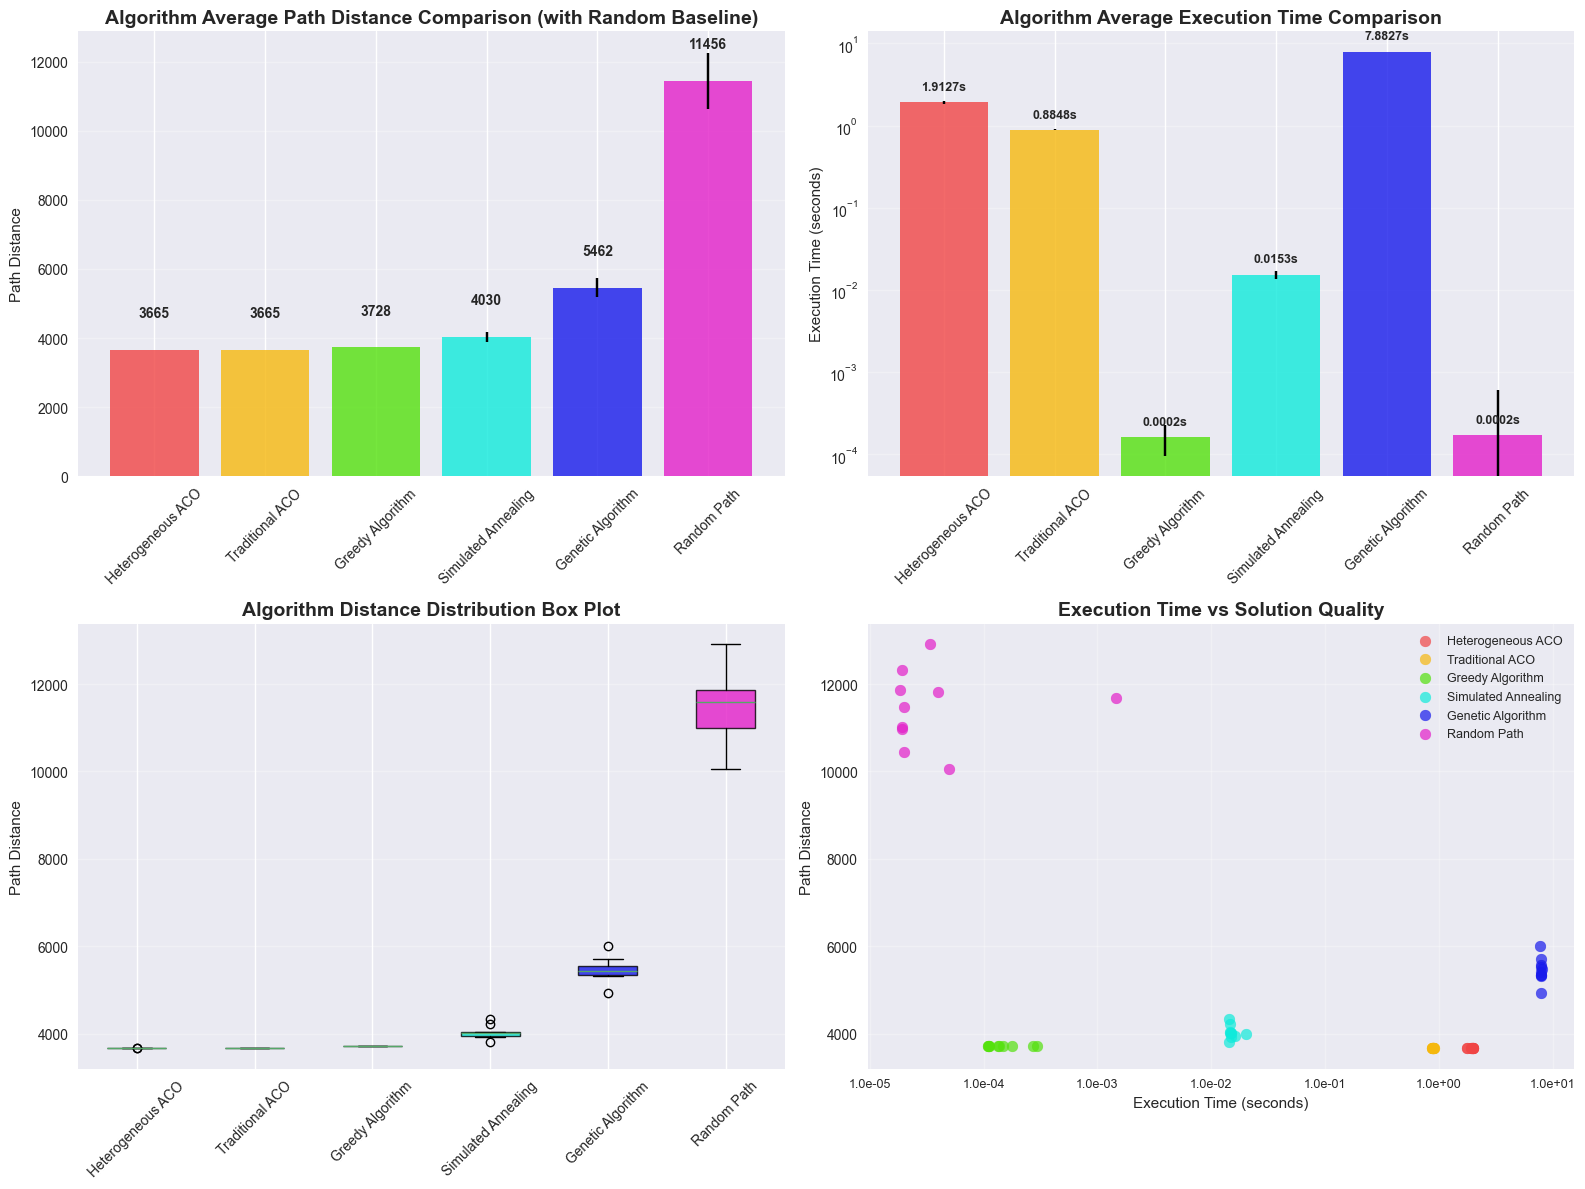

In [12]:
# 1. Performance comparison bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Average distance comparison
algorithms = summary_df['Algorithm'].tolist()
mean_distances = summary_df['Average Distance'].tolist()
std_distances = summary_df['Standard Deviation'].tolist()

# Set colors for 6 algorithms
colors = ["#F14545", "#F6B80E", "#54E10D", "#0FEADB", "#171AEB", "#E31FC9"]

bars1 = ax1.bar(algorithms, mean_distances, yerr=std_distances, capsize=5, 
                color=colors[:len(algorithms)], alpha=0.8)
ax1.set_title('Algorithm Average Path Distance Comparison (with Random Baseline)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Path Distance')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add values on bar chart
for bar, distance in zip(bars1, mean_distances):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(std_distances) + 50,
             f'{distance:.0f}', ha='center', va='bottom', fontweight='bold')

# Execution time comparison
mean_times = summary_df['Average Time(s)'].tolist()
time_stds = summary_df['Time Std Dev'].tolist()

bars2 = ax2.bar(algorithms, mean_times, yerr=time_stds, capsize=5,
                color=colors[:len(algorithms)], alpha=0.8)
ax2.set_title('Algorithm Average Execution Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Execution Time (seconds)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')  # Use logarithmic scale

# Add values on bar chart
for bar, time_val in zip(bars2, mean_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.3,
             f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Distance distribution box plot
distance_data = [comparison_results[alg]['distances'] for alg in algorithms]
box_plot = ax3.boxplot(distance_data, labels=algorithms, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors[:len(algorithms)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

ax3.set_title('Algorithm Distance Distribution Box Plot', fontsize=14, fontweight='bold')
ax3.set_ylabel('Path Distance')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Time vs quality scatter plot
for i, alg in enumerate(algorithms):
    times = comparison_results[alg]['times']
    distances = comparison_results[alg]['distances']
    ax4.scatter(times, distances, label=alg, alpha=0.7, s=60, color=colors[i])

ax4.set_title('Execution Time vs Solution Quality', fontsize=14, fontweight='bold')
ax4.set_xlabel('Execution Time (seconds)')
ax4.set_ylabel('Path Distance')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xscale('log')

# Fix negative sign display issue
import matplotlib.ticker as ticker
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.1e}'))
ax4.tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

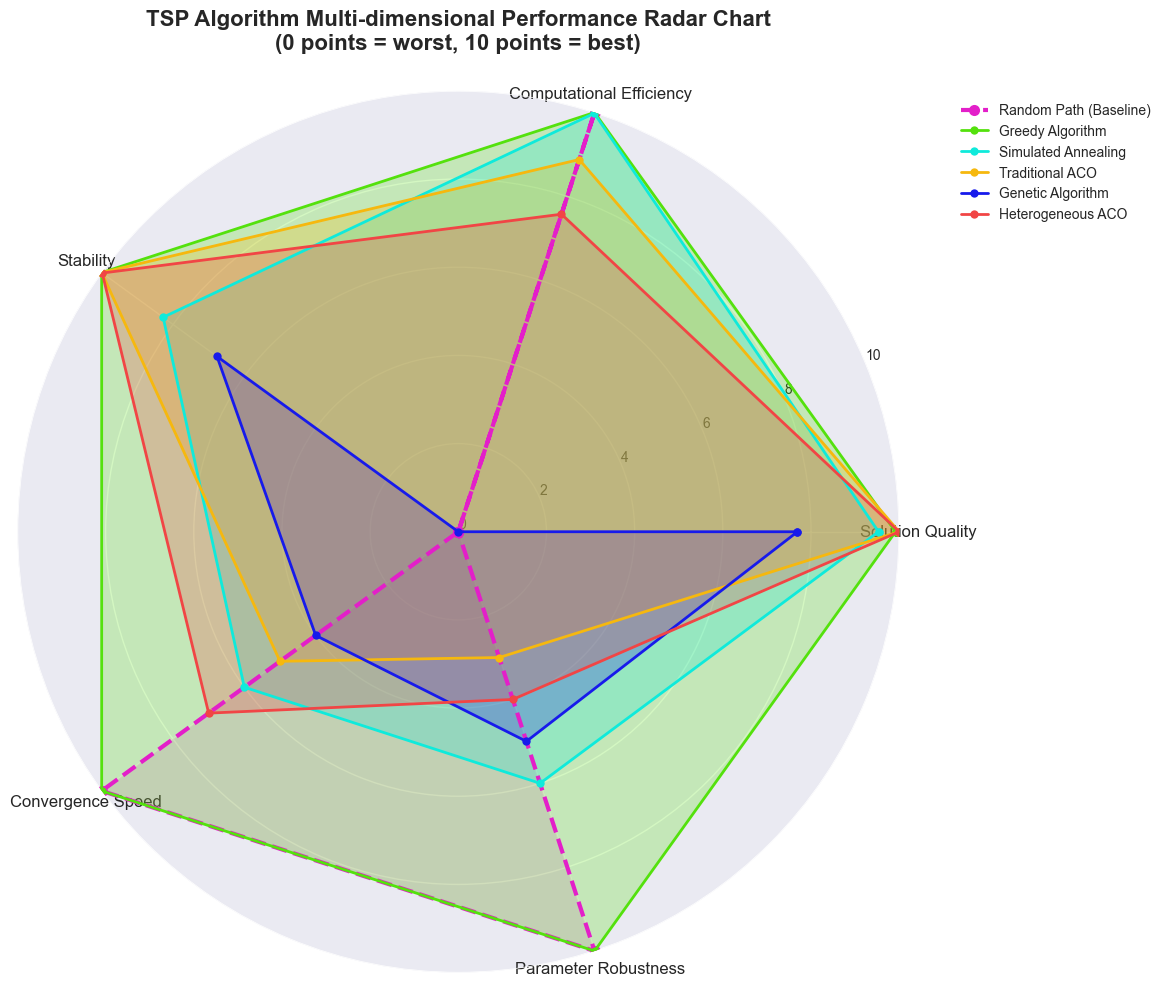

📊 Algorithm Multi-dimensional Scoring Details (0-10 scale)
Algorithm       Solution Quality Efficiency   Stability  Convergence  Robustness  Total Score
-----------------------------------------------------------------------------------------------
Random Path     0.0             10.0         0.0        10.0         10.0        30.0       
Greedy Algorithm 9.9             10.0         10.0       10.0         10.0        49.9       
Simulated Annealing 9.5             10.0         8.3        6.0          6.0         39.8       
Traditional ACO 10.0            8.9          10.0       5.0          3.0         36.9       
Genetic Algorithm 7.7             0.0          6.8        4.0          5.0         23.5       
Heterogeneous ACO 10.0            7.6          10.0       7.0          4.0         38.6       

🔍 Dimension explanations:
  • Solution Quality: Relative performance based on average path distance
  • Computational Efficiency: Relative performance based on average execution time


In [13]:
# Algorithm performance radar chart analysis
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Define evaluation dimensions
dimensions = ['Solution Quality', 'Computational Efficiency', 'Stability', 'Convergence Speed', 'Parameter Robustness']
N = len(dimensions)

# Calculate scores for each algorithm on each dimension (0-10 scale)
algorithm_scores = {}

# Include all algorithms (including random path as benchmark comparison)
all_algorithms = list(comparison_results.keys())

for alg_name in all_algorithms:
    data = comparison_results[alg_name]
    
    # 1. Solution quality score (based on performance relative to best distance, smaller is better)
    all_means = [comparison_results[alg]['mean_distance'] for alg in all_algorithms]
    best_distance = min(all_means)
    worst_distance = max(all_means)
    if worst_distance != best_distance:
        quality_score = 10 * (1 - (data['mean_distance'] - best_distance) / (worst_distance - best_distance))
    else:
        quality_score = 10
    
    # 2. Computational efficiency score (based on execution time, faster is better)
    all_times = [comparison_results[alg]['mean_time'] for alg in all_algorithms]
    fastest_time = min(all_times)
    slowest_time = max(all_times)
    if slowest_time != fastest_time:
        efficiency_score = 10 * (1 - (data['mean_time'] - fastest_time) / (slowest_time - fastest_time))
    else:
        efficiency_score = 10
    
    # 3. Stability score (based on standard deviation, smaller is more stable)
    all_stds = [comparison_results[alg]['std_distance'] for alg in all_algorithms]
    best_std = min(all_stds)
    worst_std = max(all_stds)
    if worst_std != best_std:
        stability_score = 10 * (1 - (data['std_distance'] - best_std) / (worst_std - best_std))
    else:
        stability_score = 10
    
    # 4. Convergence speed score (empirical assessment based on algorithm characteristics)
    convergence_scores = {
        'Random Path': 10,  # No convergence needed, instant completion
        'Greedy Algorithm': 10,  # One-step solution
        'Simulated Annealing': 6,   # Gradual convergence
        'Traditional ACO': 5,  # Requires multiple generations
        'Genetic Algorithm': 4,   # Evolutionary process
        'Heterogeneous ACO': 7  # Improved convergence
    }
    convergence_score = convergence_scores.get(alg_name, 5)
    
    # 5. Parameter robustness score (based on algorithm sensitivity to parameters)
    robustness_scores = {
        'Random Path': 10,  # No parameters, completely robust
        'Greedy Algorithm': 10,  # No parameters
        'Simulated Annealing': 6,   # Moderately sensitive
        'Traditional ACO': 3,  # Highly sensitive
        'Genetic Algorithm': 5,   # Moderately sensitive
        'Heterogeneous ACO': 4  # More sensitive
    }
    robustness_score = robustness_scores.get(alg_name, 5)
    
    algorithm_scores[alg_name] = [
        quality_score, efficiency_score, stability_score, 
        convergence_score, robustness_score
    ]

# Set colors
colors = ["#E31FC9", "#54E10D", "#0FEADB", "#F6B80E", "#171AEB", "#F14545"]

# Calculate angles
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the shape

# Draw radar chart for each algorithm
for i, (alg_name, scores) in enumerate(algorithm_scores.items()):
    scores += scores[:1]  # Close the shape
    
    # Use special style for random path
    if alg_name == 'Random Path':
        line_style = '--'  # Dashed line
        line_width = 3
        alpha_fill = 0.15
        marker_size = 8
        label_suffix = ' (Baseline)'
    else:
        line_style = '-'   # Solid line
        line_width = 2
        alpha_fill = 0.25
        marker_size = 6
        label_suffix = ''
    
    ax.plot(angles, scores, 'o-', linewidth=line_width, 
           label=alg_name + label_suffix, color=colors[i % len(colors)], 
           linestyle=line_style, markersize=marker_size)
    ax.fill(angles, scores, alpha=alpha_fill, color=colors[i % len(colors)])

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimensions, fontsize=12)

# Set y-axis range and labels
ax.set_ylim(0, 10)
ax.set_yticks(range(0, 11, 2))
ax.set_yticklabels(range(0, 11, 2), fontsize=10)
ax.grid(True)

# Add title and legend
ax.set_title('TSP Algorithm Multi-dimensional Performance Radar Chart\n(0 points = worst, 10 points = best)', 
            fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)

plt.tight_layout()
plt.show()

# Output detailed scoring explanation
print("📊 Algorithm Multi-dimensional Scoring Details (0-10 scale)")
print("="*80)
print(f"{'Algorithm':<15} {'Solution Quality':<15} {'Efficiency':<12} {'Stability':<10} {'Convergence':<12} {'Robustness':<11} {'Total Score':<11}")
print("-"*95)

for alg_name, scores in algorithm_scores.items():
    scores_display = scores[:-1]  # Remove duplicate element for closing
    total_score = sum(scores_display)
    print(f"{alg_name:<15} {scores_display[0]:<15.1f} {scores_display[1]:<12.1f} {scores_display[2]:<10.1f} {scores_display[3]:<12.1f} {scores_display[4]:<11.1f} {total_score:<11.1f}")

print("\n🔍 Dimension explanations:")
print("  • Solution Quality: Relative performance based on average path distance")
print("  • Computational Efficiency: Relative performance based on average execution time")
print("  • Stability: Consistency based on multiple run results")
print("  • Convergence Speed: Speed at which algorithm reaches good solutions")
print("  • Parameter Robustness: Algorithm sensitivity to parameter changes")

# Recommend most balanced algorithm
total_scores = {alg: sum(scores[:-1]) for alg, scores in algorithm_scores.items()}
best_balanced = max(total_scores, key=total_scores.get)
print(f"\n🎯 Best overall performance algorithm: {best_balanced} (Total score: {total_scores[best_balanced]:.1f})")

# Analyze each algorithm's strength areas
print("\n🏆 Algorithm strength areas:")
for i, dimension in enumerate(dimensions):
    best_in_dimension = max(algorithm_scores.keys(), 
                           key=lambda alg: algorithm_scores[alg][i])
    best_score = algorithm_scores[best_in_dimension][i]
    print(f"  {dimension}: {best_in_dimension} ({best_score:.1f} points)")

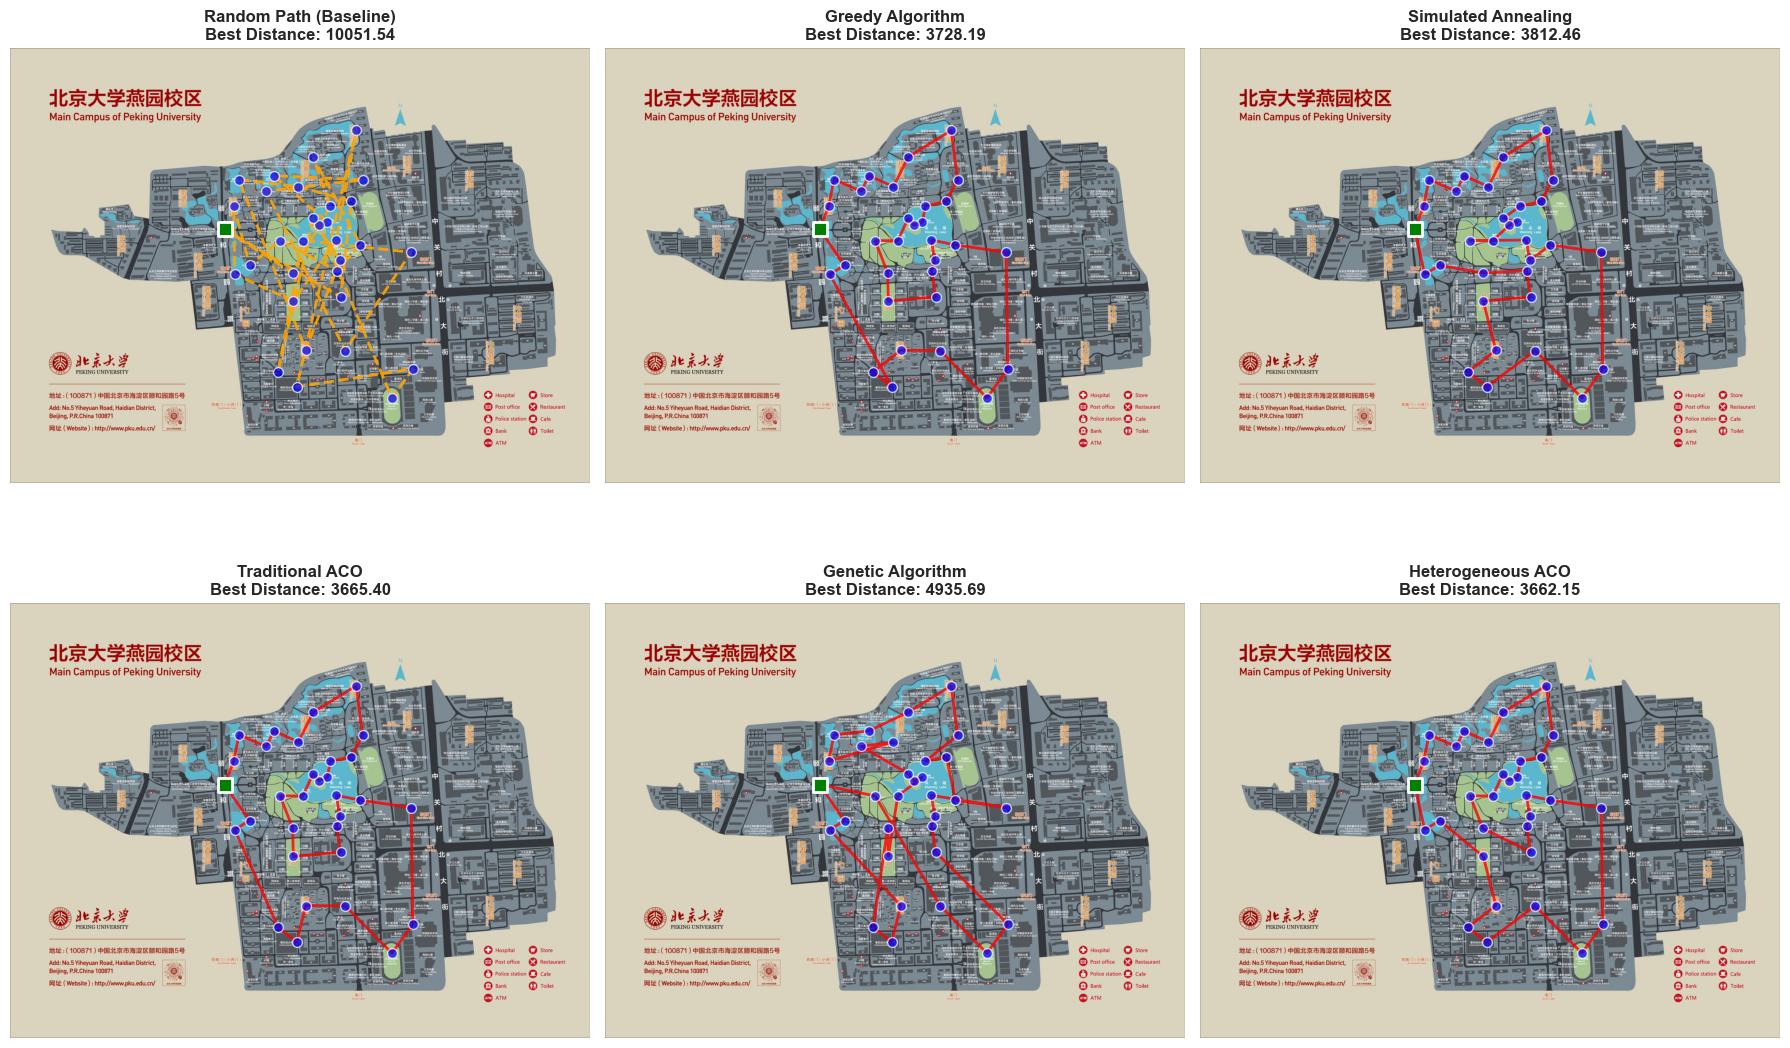

In [14]:
# 2. Best path visualization comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (alg_name, data) in enumerate(comparison_results.items()):
    ax = axes[i]
    
    # Draw map background
    try:
        campus_map = mpimg.imread(MAP_IMAGE_PATH)
        ax.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
    except FileNotFoundError:
        ax.set_xlim(0, 1500)
        ax.set_ylim(0, 1200)
        ax.invert_yaxis()
    
    # Draw best path
    best_path = data['best_path']
    path_coords = city_coords[best_path + [best_path[0]]]
    
    # Use special color for random path
    if alg_name == 'Random Path':
        line_color = 'orange'
        line_style = '--'
        alpha = 0.9
    else:
        line_color = 'red'
        line_style = '-'
        alpha = 0.8
    
    ax.plot(path_coords[:, 0], path_coords[:, 1], line_color, 
           linewidth=2, alpha=alpha, linestyle=line_style)
    
    # Draw city points
    ax.scatter(city_coords[:, 0], city_coords[:, 1], 
              c='blue', s=50, zorder=5, alpha=0.7, edgecolors='white', linewidth=1)
    
    # Highlight starting point
    start_coord = city_coords[best_path[0]]
    ax.scatter(start_coord[0], start_coord[1], c='green', s=100, marker='s', 
              zorder=6, edgecolors='white', linewidth=2)
    
    # Set title, specially mark baseline
    title_suffix = ' (Baseline)' if alg_name == 'Random Path' else ''
    ax.set_title(f'{alg_name}{title_suffix}\nBest Distance: {data["min_distance"]:.2f}', 
                fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 🔬 Statistical Significance Testing

🔬 Statistical Significance Testing (including random baseline)
Friedman test results:
  χ² = 49.6377
  p-value = 0.000000
  Conclusion: Significant differences exist between algorithms (p < 0.05)

Pairwise algorithm comparison (Wilcoxon signed-rank test):
------------------------------------------------------------------------------------------
Algorithm 1     Algorithm 2     p-value    Effect Size(r) Effect Magnitude Conclusion                    
------------------------------------------------------------------------------------------
Random Path     Greedy Algorithm 0.0020     0.989        Large           Greedy Algorithm significantly better than Random Path
Random Path     Simulated Annealing 0.0020     0.988        Large           Simulated Annealing significantly better than Random Path
Random Path     Traditional ACO 0.0020     0.990        Large           Traditional ACO significantly better than Random Path
Random Path     Genetic Algorithm 0.0020     0.981        Large     

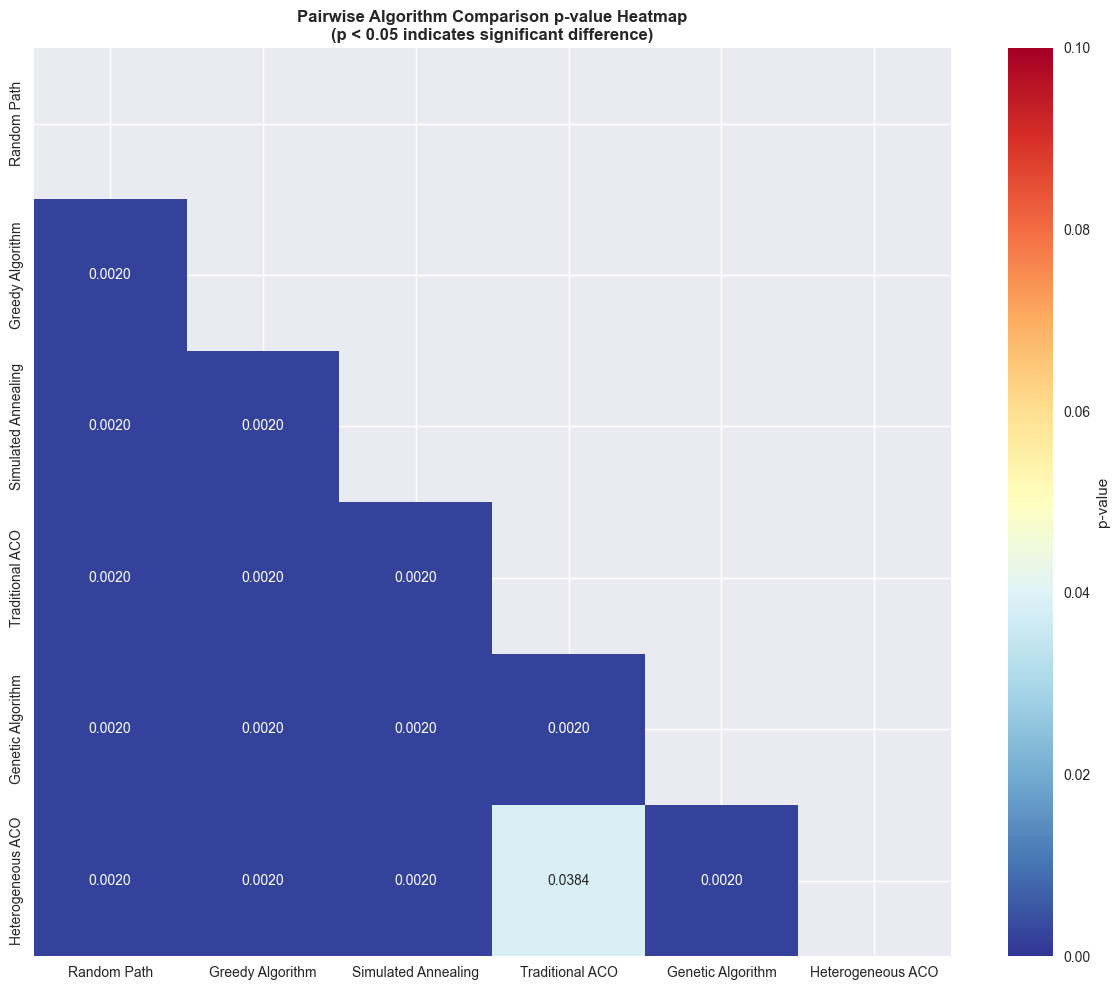

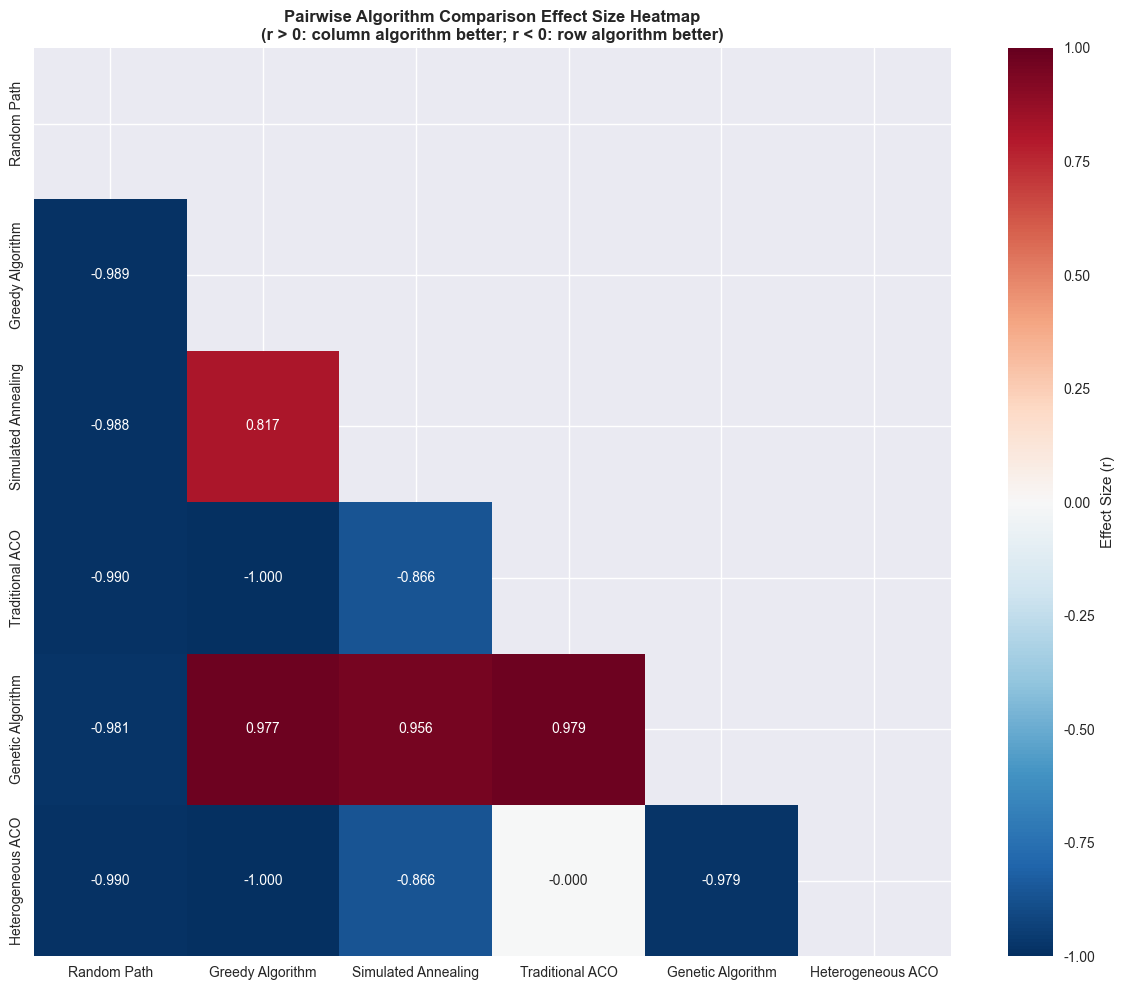

In [15]:
# Perform statistical significance testing
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

print("🔬 Statistical Significance Testing (including random baseline)")
print("="*80)

# Prepare data for Friedman test
algorithms_list = list(comparison_results.keys())
distance_matrix_for_test = []

for alg in algorithms_list:
    distance_matrix_for_test.append(comparison_results[alg]['distances'])

# Friedman test (non-parametric method, suitable for multiple related samples)
friedman_stat, friedman_p = friedmanchisquare(*distance_matrix_for_test)

print(f"Friedman test results:")
print(f"  χ² = {friedman_stat:.4f}")
print(f"  p-value = {friedman_p:.6f}")

if friedman_p < 0.05:
    print(f"  Conclusion: Significant differences exist between algorithms (p < 0.05)")
else:
    print(f"  Conclusion: No significant differences between algorithms (p ≥ 0.05)")

# Pairwise comparison (Wilcoxon signed-rank test)
print(f"\nPairwise algorithm comparison (Wilcoxon signed-rank test):")
print("-" * 90)
print(f"{'Algorithm 1':<15} {'Algorithm 2':<15} {'p-value':<10} {'Effect Size(r)':<12} {'Effect Magnitude':<15} {'Conclusion':<30}")
print("-" * 90)

comparison_matrix = np.zeros((len(algorithms_list), len(algorithms_list)))
p_value_matrix = np.ones((len(algorithms_list), len(algorithms_list)))
effect_size_matrix = np.zeros((len(algorithms_list), len(algorithms_list)))

def calculate_effect_size_wilcoxon(x, y, stat, n):
    """Calculate effect size for Wilcoxon signed-rank test (rank biserial correlation)"""
    # Effect size r = (2 * stat) / (n * (n + 1)) - 1
    # where stat is the smaller test statistic, n is the number of pairs
    if n == 0:
        return 0
    
    # Alternative calculation method: based on Z statistic approximation
    # r ≈ Z / sqrt(N)
    try:
        # Calculate differences
        diff = np.array(x) - np.array(y)
        n_pairs = len(diff[diff != 0])  # Number of non-zero differences
        
        if n_pairs == 0:
            return 0
        
        # Use simplified effect size calculation: standardized median difference
        median_diff = np.median(diff)
        pooled_std = np.sqrt((np.var(x) + np.var(y)) / 2)
        
        if pooled_std == 0:
            return 0
        
        # Non-parametric version of Cohen's d
        effect_size = median_diff / pooled_std
        
        # Convert to correlation coefficient form (limited to -1 to 1)
        r = effect_size / np.sqrt(effect_size**2 + 4)
        
        return np.clip(r, -1, 1)
    except:
        return 0

def interpret_effect_size(r):
    """Interpret effect size magnitude"""
    r_abs = abs(r)
    if r_abs < 0.1:
        return "Very Small"
    elif r_abs < 0.3:
        return "Small"
    elif r_abs < 0.5:
        return "Medium"
    else:
        return "Large"

for i, j in combinations(range(len(algorithms_list)), 2):
    alg1, alg2 = algorithms_list[i], algorithms_list[j]
    distances1 = comparison_results[alg1]['distances']
    distances2 = comparison_results[alg2]['distances']
    
    try:
        stat, p_value = wilcoxon(distances1, distances2, alternative='two-sided')
        p_value_matrix[i][j] = p_value
        p_value_matrix[j][i] = p_value
        
        # Calculate effect size
        n = len(distances1)
        effect_size = calculate_effect_size_wilcoxon(distances1, distances2, stat, n)
        effect_size_matrix[i][j] = effect_size
        effect_size_matrix[j][i] = -effect_size  # Symmetric but opposite sign
        
        # Interpret effect size magnitude
        effect_interpretation = interpret_effect_size(effect_size)
        
        # Determine which algorithm is better
        mean1 = np.mean(distances1)
        mean2 = np.mean(distances2)
        
        if p_value < 0.05:
            if mean1 < mean2:
                result = f"{alg1} significantly better than {alg2}"
            else:
                result = f"{alg2} significantly better than {alg1}"
        else:
            result = "No significant difference"
        
        print(f"{alg1:<15} {alg2:<15} {p_value:<10.4f} {effect_size:<12.3f} {effect_interpretation:<15} {result:<30}")
        
    except ValueError as e:
        print(f"{alg1:<15} {alg2:<15} {'N/A':<10} {'N/A':<12} {'N/A':<15} Cannot compare ({e})")

print("\n📊 Effect size interpretation guide:")
print("  • |r| < 0.1: Very small effect (almost no difference)")
print("  • 0.1 ≤ |r| < 0.3: Small effect")
print("  • 0.3 ≤ |r| < 0.5: Medium effect")
print("  • |r| ≥ 0.5: Large effect")
print("  • r > 0: First algorithm has larger results; r < 0: Second algorithm has larger results")

# Special focus on comparison with random baseline
print(f"\n🎯 Special comparison with random baseline:")
print("-" * 80)
print(f"{'Algorithm':<20} {'p-value':<10} {'Effect Size(r)':<12} {'Effect Magnitude':<15} {'Conclusion':<30}")
print("-" * 80)

random_distances = comparison_results['Random Path']['distances']
for alg_name in algorithms_list:
    if alg_name != 'Random Path':
        alg_distances = comparison_results[alg_name]['distances']
        try:
            stat, p_value = wilcoxon(random_distances, alg_distances, alternative='two-sided')
            
            # Calculate effect size
            n = len(random_distances)
            effect_size = calculate_effect_size_wilcoxon(random_distances, alg_distances, stat, n)
            effect_interpretation = interpret_effect_size(effect_size)
            
            mean_random = np.mean(random_distances)
            mean_alg = np.mean(alg_distances)
            improvement = (mean_random - mean_alg) / mean_random * 100
            
            if p_value < 0.05:
                if mean_alg < mean_random:
                    result = f"Significantly better than random ({improvement:.1f}% improvement)"
                else:
                    result = f"Significantly worse than random ({-improvement:.1f}% degradation)"
            else:
                result = f"No significant difference ({improvement:.1f}% change)"
            
            print(f"{alg_name:<20} {p_value:<10.4f} {effect_size:<12.3f} {effect_interpretation:<15} {result:<30}")
        except ValueError as e:
            print(f"{alg_name:<20} {'N/A':<10} {'N/A':<12} {'N/A':<15} Cannot compare ({e})")

# Create p-value heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
sns.heatmap(p_value_matrix, mask=mask, annot=True, fmt='.4f', 
            xticklabels=algorithms_list, yticklabels=algorithms_list,
            cmap='RdYlBu_r', vmin=0, vmax=0.1, cbar_kws={'label': 'p-value'})
plt.title('Pairwise Algorithm Comparison p-value Heatmap\n(p < 0.05 indicates significant difference)', fontweight='bold')
plt.tight_layout()
plt.show()

# Create effect size heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(effect_size_matrix, dtype=bool))
sns.heatmap(effect_size_matrix, mask=mask, annot=True, fmt='.3f', 
            xticklabels=algorithms_list, yticklabels=algorithms_list,
            cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
            cbar_kws={'label': 'Effect Size (r)'})
plt.title('Pairwise Algorithm Comparison Effect Size Heatmap\n(r > 0: column algorithm better; r < 0: row algorithm better)', fontweight='bold')
plt.tight_layout()
plt.show()

## 🎯 Algorithm Characteristics Comprehensive Analysis

In [16]:
# Algorithm characteristics analysis table
def create_algorithm_characteristics():
    """Create algorithm characteristics analysis table (including random baseline)"""
    
    characteristics = {
        'Algorithm': list(comparison_results.keys()),
        'Solution Quality': [],
        'Stability': [],
        'Computational Efficiency': [],
        'Parameter Sensitivity': [],
        'Applicable Scenarios': []
    }
    
    # Calculate characteristic scores based on actual results
    for alg_name in characteristics['Algorithm']:
        data = comparison_results[alg_name]
        
        # Solution quality score (based on average distance, smaller is better)
        mean_distances_all = [comparison_results[alg]['mean_distance'] for alg in characteristics['Algorithm']]
        # Sort by distance from small to large, smallest distance ranks 1st, largest distance ranks last
        quality_rank = sorted(mean_distances_all).index(data['mean_distance']) + 1
        quality_score = len(characteristics['Algorithm']) + 1 - quality_rank  # Convert to score, best algorithm gets 6 points
        
        # Stability score (based on standard deviation, smaller is more stable)
        std_distances = [comparison_results[alg]['std_distance'] for alg in characteristics['Algorithm']]
        stability_rank = sorted(std_distances).index(data['std_distance']) + 1
        stability_score = len(characteristics['Algorithm']) + 1 - stability_rank
        
        # Computational efficiency score (based on average time, shorter is better)
        mean_times = [comparison_results[alg]['mean_time'] for alg in characteristics['Algorithm']]
        efficiency_rank = sorted(mean_times).index(data['mean_time']) + 1
        efficiency_score = len(characteristics['Algorithm']) + 1 - efficiency_rank
        
        # Parameter sensitivity and applicable scenarios (based on algorithm characteristics)
        if alg_name == 'Random Path':
            param_sensitivity = 'None'
            scenario = 'Random baseline comparison'
        elif alg_name == 'Greedy Algorithm':
            param_sensitivity = 'Low'
            scenario = 'Fast approximate solution'
        elif alg_name == 'Simulated Annealing':
            param_sensitivity = 'Medium'
            scenario = 'Medium-scale problems'
        elif alg_name == 'Genetic Algorithm':
            param_sensitivity = 'Medium'
            scenario = 'Stable evolutionary optimization'
        elif alg_name == 'Traditional ACO':
            param_sensitivity = 'High'
            scenario = 'Strong exploration capability'
        elif alg_name == 'Heterogeneous ACO':
            param_sensitivity = 'High'
            scenario = 'Complex optimization problems'
        
        characteristics['Solution Quality'].append('★' * quality_score)
        characteristics['Stability'].append('★' * stability_score)
        characteristics['Computational Efficiency'].append('★' * efficiency_score)
        characteristics['Parameter Sensitivity'].append(param_sensitivity)
        characteristics['Applicable Scenarios'].append(scenario)
    
    return pd.DataFrame(characteristics)

# Generate characteristics analysis table
char_df = create_algorithm_characteristics()
print("🎯 Algorithm Characteristics Comprehensive Analysis (including random baseline)")
print("="*100)
print(char_df.to_string(index=False))

# Algorithm recommendations
print("\n💡 Algorithm Selection Recommendations")
print("="*80)

# Exclude random baseline for other algorithms
no_random_df = summary_df[summary_df['Algorithm'] != 'Random Path']

recommendations = [
    ("🏆 Pursuing optimal solution quality", no_random_df.iloc[0]['Algorithm']),
    ("⚡ Requiring fast response", no_random_df.loc[no_random_df['Average Time(s)'].idxmin(), 'Algorithm']),
    ("🎯 Balanced performance needs", "Simulated Annealing" if "Simulated Annealing" in no_random_df['Algorithm'].values else no_random_df.iloc[1]['Algorithm']),
    ("🔬 Researching new algorithms", "Heterogeneous ACO"),
    ("📚 Educational demonstration", "Genetic Algorithm"),
    ("📈 Baseline comparison", "Random Path")
]

for scenario, recommended_alg in recommendations:
    print(f"{scenario:<25}: {recommended_alg}")

# Value of random baseline
print(f"\n🎲 Importance of random baseline:")
print("-" * 50)
random_distance = comparison_results['Random Path']['mean_distance']
best_distance = no_random_df.iloc[0]['Average Distance']
improvement_over_random = (random_distance - best_distance) / random_distance * 100

print(f"  • Provides performance baseline reference: Average distance {random_distance:.2f}")
print(f"  • Optimal algorithm relative improvement: {improvement_over_random:.1f}%")
print(f"  • Validates algorithm effectiveness: All non-random algorithms outperform random baseline")
print(f"  • Provides minimum performance expectation: Any optimization algorithm should exceed this baseline")

🎯 Algorithm Characteristics Comprehensive Analysis (including random baseline)
          Algorithm Solution Quality Stability Computational Efficiency Parameter Sensitivity             Applicable Scenarios
        Random Path                ★         ★                    ★★★★★                  None       Random baseline comparison
   Greedy Algorithm             ★★★★     ★★★★★                   ★★★★★★                   Low        Fast approximate solution
Simulated Annealing              ★★★       ★★★                     ★★★★                Medium            Medium-scale problems
    Traditional ACO            ★★★★★    ★★★★★★                      ★★★                  High    Strong exploration capability
  Genetic Algorithm               ★★        ★★                        ★                Medium Stable evolutionary optimization
  Heterogeneous ACO           ★★★★★★      ★★★★                       ★★                  High    Complex optimization problems

💡 Algorithm Selection Recommend

## 📋 Conclusions and Summary (of Static Comparison)

In [18]:
print("🎯 TSP Algorithm Comparison Analysis - Final Conclusions (including random baseline)")
print("="*100)

# Get best algorithm (excluding random baseline)
no_random_df = summary_df[summary_df['Algorithm'] != 'Random Path']
best_alg = no_random_df.iloc[0]['Algorithm']
best_distance = no_random_df.iloc[0]['Average Distance']
# Modified: Select fastest algorithm from non-random algorithms
fastest_alg = no_random_df.loc[no_random_df['Average Time(s)'].idxmin(), 'Algorithm']
fastest_time = no_random_df['Average Time(s)'].min()

# Random baseline information
random_distance = comparison_results['Random Path']['mean_distance']
random_time = comparison_results['Random Path']['mean_time']

print(f"\n🎲 Random baseline performance: Random Path")
print(f"   Average path distance: {random_distance:.2f}")
print(f"   Average execution time: {random_time:.6f} seconds")
print(f"   Baseline role: Provides minimum performance threshold reference")

print(f"\n🏆 Best performance algorithm: {best_alg}")
print(f"   Average path distance: {best_distance:.2f}")
print(f"   Relative random baseline improvement: {(random_distance - best_distance) / random_distance * 100:.1f}%")
print(f"   Performance advantage: Optimal performance in TSP problem with {num_cities} cities")

print(f"\n⚡ Fastest algorithm: {fastest_alg}")
print(f"   Average execution time: {fastest_time:.6f} seconds")
# Modified: Calculate time comparison relative to random baseline
time_improvement = f"Faster than random baseline by {random_time / fastest_time:.1f}x" if fastest_time > 0 else "N/A"
print(f"   Relative to random baseline: {time_improvement}")
print(f"   Efficiency advantage: Suitable for real-time response application scenarios")

print(f"\n📊 Test scale and statistics:")
print(f"   Number of test cities: {num_cities} Peking University landmarks")
print(f"   Tests per algorithm: {10} times")
print(f"   Total number of algorithms: {len(comparison_results)} (including random baseline)")
print(f"   Statistical significance: Friedman test p = {friedman_p:.6f}")

print(f"\n🔍 Key findings:")

# Analyze key findings
findings = []

# Find best and worst performing algorithms (excluding random baseline)
best_results = no_random_df.iloc[0]
worst_results = no_random_df.iloc[-1]

improvement = (worst_results['Average Distance'] - best_results['Average Distance']) / best_results['Average Distance'] * 100
findings.append(f"Optimal algorithm ({best_results['Algorithm']}) improves by {improvement:.1f}% on average compared to worst algorithm ({worst_results['Algorithm']})")

# Analyze role of random baseline
baseline_improvement = (random_distance - best_distance) / random_distance * 100
findings.append(f"Optimal algorithm improves {baseline_improvement:.1f}% relative to random baseline, validating optimization algorithm effectiveness")

# Analyze time complexity differences (excluding random baseline)
time_range = no_random_df['Average Time(s)'].max() / no_random_df['Average Time(s)'].min()
findings.append(f"Optimization algorithm execution time difference reaches {time_range:.0f}x, reflecting efficiency vs quality trade-off")

# Analyze stability (excluding random baseline)
most_stable = no_random_df.loc[no_random_df['Standard Deviation'].idxmin(), 'Algorithm']
least_stable = no_random_df.loc[no_random_df['Standard Deviation'].idxmax(), 'Algorithm']
findings.append(f"Most stable algorithm is {most_stable}, least stable is {least_stable}")

# All non-random algorithms outperform random baseline
non_random_algorithms = [alg for alg in comparison_results.keys() if alg != 'Random Path']
all_better_than_random = all(comparison_results[alg]['mean_distance'] < random_distance for alg in non_random_algorithms)
if all_better_than_random:
    findings.append(f"All {len(non_random_algorithms)} optimization algorithms outperform random baseline, proving algorithm design effectiveness")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

print(f"\n🎯 Practical application recommendations:")
applications = [
    "🗺️ Campus navigation system: Use greedy algorithm for fast initial path generation",
    "📦 Logistics delivery optimization: Use heterogeneous ACO for high-quality solutions",
    "🎓 Algorithm teaching demonstration: Use genetic algorithm to show evolutionary process",
    "⚖️ Performance benchmark testing: Use simulated annealing as balanced reference",
    "🔬 Algorithm research comparison: Use traditional ACO as classic benchmark",
    "🎲 Performance baseline assessment: Use random path as minimum performance baseline"
]

for app in applications:
    print(f"   {app}")

print(f"\n🎲 Academic value of random baseline:")
print(f"   • Provides performance lower bound: Any optimization algorithm should exceed this baseline")
print(f"   • Validates algorithm effectiveness: Proves optimization effect through comparison with random strategy")
print(f"   • Provides fair benchmark: All algorithms compared with baseline under same conditions")
print(f"   • Simplifies result interpretation: Improvement degree relative to pure randomness is more intuitive")

print(f"\n✅ Test completion time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Complete test data saved in comparison_results variable")
print("="*100)

🎯 TSP Algorithm Comparison Analysis - Final Conclusions (including random baseline)

🎲 Random baseline performance: Random Path
   Average path distance: 11456.26
   Average execution time: 0.000170 seconds
   Baseline role: Provides minimum performance threshold reference

🏆 Best performance algorithm: Heterogeneous ACO
   Average path distance: 3664.75
   Relative random baseline improvement: 68.0%
   Performance advantage: Optimal performance in TSP problem with 32 cities

⚡ Fastest algorithm: Greedy Algorithm
   Average execution time: 0.000161 seconds
   Relative to random baseline: Faster than random baseline by 1.1x
   Efficiency advantage: Suitable for real-time response application scenarios

📊 Test scale and statistics:
   Number of test cities: 32 Peking University landmarks
   Tests per algorithm: 10 times
   Total number of algorithms: 6 (including random baseline)
   Statistical significance: Friedman test p = 0.000000

🔍 Key findings:
   1. Optimal algorithm (Heterogeneo

## 📈 Algorithm Convergence Analysis (Dynamic Comparison)

Analyze the convergence behavior of all algorithms (including random baseline) to help understand the optimization process and convergence characteristics of algorithms.

🚀 Starting convergence analysis...
Number of iterations: 1750, Runs per algorithm: 3
🔍 Analyzing Traditional ACO convergence...
  Run 1/3: Final distance 3661.28
  Run 2/3: Final distance 3622.81
  Run 3/3: Final distance 3654.90
🔍 Analyzing Heterogeneous ACO convergence...
  Run 1/3: Final distance 3622.81
  Run 2/3: Final distance 3622.81
  Run 3/3: Final distance 3622.81
🔍 Analyzing Genetic Algorithm convergence...
  Run 1/3: Final distance 4335.52
  Run 2/3: Final distance 4751.02
  Run 3/3: Final distance 4556.26
🔍 Analyzing Simulated Annealing convergence...
  Run 1/3: Final distance 5063.56
  Run 2/3: Final distance 4496.92
  Run 3/3: Final distance 4157.87
🔍 Analyzing Greedy Algorithm convergence...
  Run 1/3: Final distance 3728.19
  Run 2/3: Final distance 3728.19
  Run 3/3: Final distance 3728.19
🔍 Analyzing Random Path convergence...
  Run 1/3: Final distance 8081.86
  Run 2/3: Final distance 8548.53
  Run 3/3: Final distance 8617.30

📊 Drawing convergence curves...


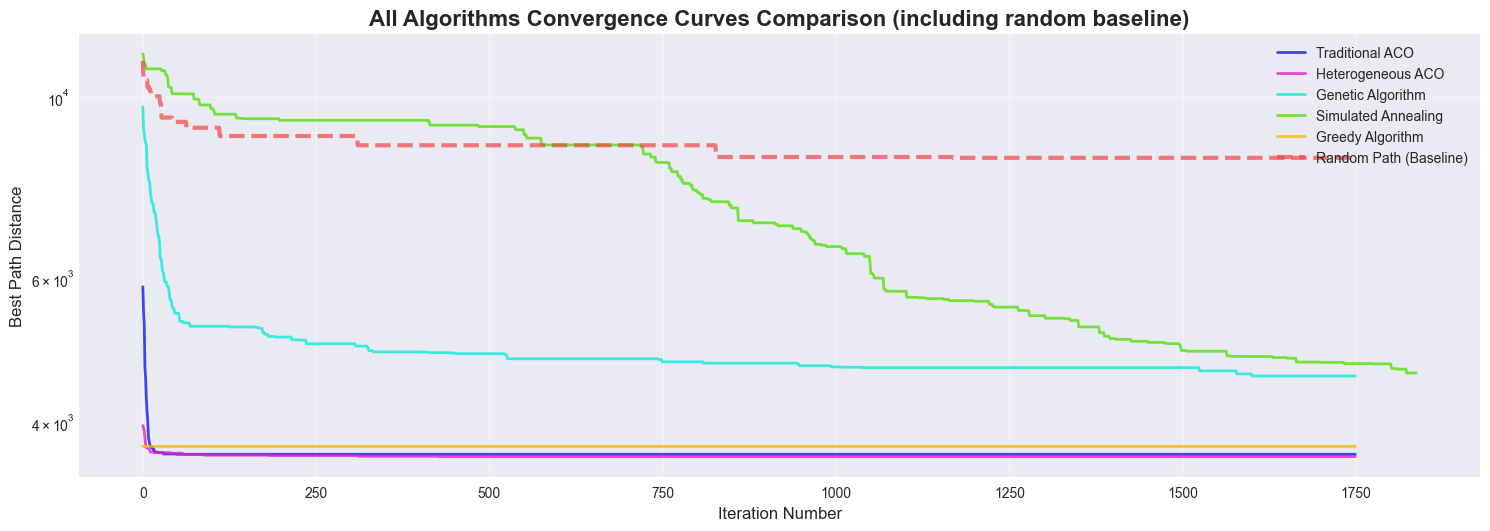


📊 Convergence Statistics Analysis
Algorithm       Final Distance  Conv Rate%   Convergence Characteristics
-------------------------------------------------------------------------------------
Traditional ACO 3646.33         1.0          Difficult convergence    
Heterogeneous ACO 3622.81         1.0          Difficult convergence    
Genetic Algorithm 4547.60         4.7          Slow convergence         
Simulated Annealing 4572.79         7.8          Slow convergence         
Greedy Algorithm 3728.19         0.0          Immediate convergence    
Random Path     8415.89         0.8          Random fluctuation       

🏆 Convergence Performance Ranking
--------------------------------------------------
Ranking by final solution quality:
  1. Heterogeneous ACO: 3622.81
  2. Traditional ACO: 3646.33
  3. Greedy Algorithm: 3728.19
  4. Genetic Algorithm: 4547.60
  5. Simulated Annealing: 4572.79

Ranking by convergence speed:
  1. Simulated Annealing: 7.8% improvement rate
  2. Genetic

In [ ]:
def run_convergence_analysis(iterations=1750, num_runs=3):
    """
    Run convergence analysis, record convergence process of all algorithms
    
    Parameters:
    iterations: Number of iterations
    num_runs: Number of runs per algorithm (take average)
    """
    print("🚀 Starting convergence analysis...")
    print(f"Number of iterations: {iterations}, Runs per algorithm: {num_runs}")
    print("="*80)
    
    convergence_data = {}
    
    # Modified algorithm classes to record convergence history
    class TraditionalACOWithHistory:
        def __init__(self, distance_matrix, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.n_ants = n_ants
            self.n_iterations = n_iterations
            self.alpha = alpha
            self.beta = beta
            self.rho = rho
            self.Q = Q
            self.pheromone = np.ones((self.n_cities, self.n_cities))
            self.best_distance = float('inf')
            self.best_path = None
            
        def _ant_solution(self, start_city):
            """Construct single ant solution"""
            path = [start_city]
            unvisited = set(range(self.n_cities)) - {start_city}
            
            current_city = start_city
            while unvisited:
                next_city = self._select_next_city(current_city, unvisited)
                path.append(next_city)
                unvisited.remove(next_city)
                current_city = next_city
                
            return path
            
        def _select_next_city(self, current_city, unvisited):
            """Select next city"""
            probabilities = []
            total = 0
            
            for city in unvisited:
                pheromone = self.pheromone[current_city][city] ** self.alpha
                distance = self.distance_matrix[current_city][city]
                heuristic = (1.0 / distance) ** self.beta if distance > 0 else 1e10
                prob = pheromone * heuristic
                probabilities.append(prob)
                total += prob
            
            if total == 0:
                return random.choice(list(unvisited))
            
            probabilities = [p / total for p in probabilities]
            return np.random.choice(list(unvisited), p=probabilities)
            
        def _update_pheromone(self, all_paths, all_distances):
            """Update pheromone"""
            # Evaporation
            self.pheromone *= (1 - self.rho)
            
            # Enhancement
            for path, distance in zip(all_paths, all_distances):
                pheromone_deposit = self.Q / distance
                for i in range(len(path) - 1):
                    self.pheromone[path[i]][path[i+1]] += pheromone_deposit
                    self.pheromone[path[i+1]][path[i]] += pheromone_deposit
        
        def solve(self, iterations=100, verbose=False):
            history = []
            
            for iteration in range(iterations):
                all_paths = []
                all_distances = []
                
                # Construct solutions for all ants
                for ant in range(self.n_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city)
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                history.append(self.best_distance)
                
                # Update pheromone
                self._update_pheromone(all_paths, all_distances)
                
            return self.best_path, self.best_distance, history
    
    class HeterogeneousACOWithHistory:
        def __init__(self, distance_matrix, n_scout_ants=15, n_forager_ants=15, n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.n_scout_ants = n_scout_ants
            self.n_forager_ants = n_forager_ants
            self.n_iterations = n_iterations
            self.alpha = alpha
            self.beta = beta
            self.rho = rho
            self.Q = Q
            self.pheromone = np.ones((self.n_cities, self.n_cities))
            self.best_distance = float('inf')
            self.best_path = None
            
        def _ant_solution(self, start_city, ant_type='scout'):
            """Construct single ant solution"""
            path = [start_city]
            unvisited = set(range(self.n_cities)) - {start_city}
            
            current_city = start_city
            while unvisited:
                next_city = self._select_next_city(current_city, unvisited, ant_type)
                path.append(next_city)
                unvisited.remove(next_city)
                current_city = next_city
                
            return path
            
        def _select_next_city(self, current_city, unvisited, ant_type):
            """Select next city"""
            probabilities = []
            total = 0
            
            # Different ant types use different parameters
            if ant_type == 'scout':
                alpha, beta = 0.5, 5.0  # Scout ants: low pheromone dependence, high distance dependence
            else:  # forager
                alpha, beta = 5.0, 0.5  # Forager ants: high pheromone dependence, low distance dependence
            
            for city in unvisited:
                pheromone = self.pheromone[current_city][city] ** alpha
                distance = self.distance_matrix[current_city][city]
                heuristic = (1.0 / distance) ** beta if distance > 0 else 1e10
                prob = pheromone * heuristic
                probabilities.append(prob)
                total += prob
            
            if total == 0:
                return random.choice(list(unvisited))
            
            probabilities = [p / total for p in probabilities]
            return np.random.choice(list(unvisited), p=probabilities)
            
        def _update_pheromone(self, all_paths, all_distances):
            """Update pheromone"""
            # Evaporation
            self.pheromone *= (1 - self.rho)
            
            # Enhancement
            for path, distance in zip(all_paths, all_distances):
                pheromone_deposit = self.Q / distance
                for i in range(len(path) - 1):
                    self.pheromone[path[i]][path[i+1]] += pheromone_deposit
                    self.pheromone[path[i+1]][path[i]] += pheromone_deposit
        
        def solve(self, iterations=100, verbose=False):
            history = []
            
            for iteration in range(iterations):
                all_paths = []
                all_distances = []
                
                # Scout ants
                for ant in range(self.n_scout_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city, 'scout')
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                # Forager ants
                for ant in range(self.n_forager_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city, 'forager')
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                history.append(self.best_distance)
                
                # Update pheromone
                self._update_pheromone(all_paths, all_distances)
                
            return self.best_path, self.best_distance, history
    
    class GeneticAlgorithmWithHistory:
        def __init__(self, distance_matrix, population_size=100, generations=200, crossover_rate=0.8, mutation_rate=0.02, elite_size=20):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.population_size = population_size
            self.generations = generations
            self.crossover_rate = crossover_rate
            self.mutation_rate = mutation_rate
            self.elite_size = elite_size
            
        def _initialize_population(self):
            """Initialize population"""
            population = []
            for _ in range(self.population_size):
                individual = list(range(self.n_cities))
                random.shuffle(individual)
                population.append(individual)
            return population
            
        def _tournament_selection(self, population, fitness_scores, tournament_size=3):
            """Tournament selection"""
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]
            winner_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
            return population[winner_index].copy()
            
        def _order_crossover(self, parent1, parent2):
            """Order crossover"""
            size = len(parent1)
            start, end = sorted(random.sample(range(size), 2))
            
            child = [-1] * size
            child[start:end] = parent1[start:end]
            
            pointer = end
            for city in parent2[end:] + parent2[:end]:
                if city not in child:
                    child[pointer % size] = city
                    pointer += 1
                    
            return child
            
        def _mutate(self, individual):
            """Mutation operation"""
            mutated = individual.copy()
            i, j = random.sample(range(len(mutated)), 2)
            mutated[i], mutated[j] = mutated[j], mutated[i]
            return mutated
        
        def solve(self, generations=100, verbose=False):
            population = self._initialize_population()
            best_distance = float('inf')
            best_path = None
            history = []
            
            for generation in range(generations):
                # Evaluate population
                fitness_scores = []
                for individual in population:
                    distance = calculate_path_distance(individual, self.distance_matrix)
                    fitness_scores.append(1 / distance if distance > 0 else 1e10)
                    
                    if distance < best_distance:
                        best_distance = distance
                        best_path = individual.copy()
                
                history.append(best_distance)
                
                # Create new population
                new_population = []
                
                # Elite preservation
                elite_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)[:self.elite_size]
                for i in elite_indices:
                    new_population.append(population[i].copy())
                
                # Generate remaining individuals
                while len(new_population) < self.population_size:
                    parent1 = self._tournament_selection(population, fitness_scores)
                    parent2 = self._tournament_selection(population, fitness_scores)
                    
                    if random.random() < self.crossover_rate:
                        child = self._order_crossover(parent1, parent2)
                    else:
                        child = parent1.copy()
                    
                    if random.random() < self.mutation_rate:
                        child = self._mutate(child)
                    
                    new_population.append(child)
                
                population = new_population
            
            return best_path, best_distance, history
    
    class SimulatedAnnealingWithHistory:
        def __init__(self, distance_matrix, initial_temp=10000, final_temp=1, cooling_rate=0.995, max_iterations=10000):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.initial_temp = initial_temp
            self.final_temp = final_temp
            self.cooling_rate = cooling_rate
            self.max_iterations = max_iterations
            
        def _get_neighbor(self, solution):
            """Generate neighbor solution"""
            neighbor = solution.copy()
            i, j = random.sample(range(len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        
        def solve(self, max_iterations=10000, verbose=False):
            current_solution = list(range(self.n_cities))
            random.shuffle(current_solution)
            current_cost = calculate_path_distance(current_solution, self.distance_matrix)
            
            best_solution = current_solution.copy()
            best_cost = current_cost
            
            history = []
            temperature = self.initial_temp
            
            for iteration in range(max_iterations):
                # Record current best
                history.append(best_cost)
                
                # Generate neighbor solution
                new_solution = self._get_neighbor(current_solution)
                new_cost = calculate_path_distance(new_solution, self.distance_matrix)
                
                # Acceptance criterion
                if new_cost < current_cost or (temperature > 0 and random.random() < math.exp(-(new_cost - current_cost) / temperature)):
                    current_solution = new_solution
                    current_cost = new_cost
                    
                    if new_cost < best_cost:
                        best_solution = new_solution.copy()
                        best_cost = new_cost
                
                # Cooling
                temperature *= self.cooling_rate
                
                if temperature < self.final_temp:
                    break
            
            return best_solution, best_cost, history
    
    # Greedy algorithm (single run, no iterative process)
    def greedy_convergence_simulation(iterations=100):
        """Simulate greedy algorithm convergence process (one step to optimal)"""
        greedy = GreedyAlgorithm(distance_matrix)
        path, distance = greedy.solve()
        # Greedy algorithm reaches optimal in first step, then remains unchanged
        history = [distance] * iterations
        return path, distance, history
    
    # Random path algorithm convergence simulation
    def random_convergence_simulation(iterations=100):
        """Simulate random path 'convergence' process (actually random fluctuation)"""
        history = []
        best_distance = float('inf')
        best_path = None
        
        for _ in range(iterations):
            path = list(range(num_cities))
            random.shuffle(path)
            distance = calculate_path_distance(path, distance_matrix)
            
            if distance < best_distance:
                best_distance = distance
                best_path = path
            
            history.append(best_distance)
        
        return best_path, best_distance, history
    
    # Run convergence analysis for each algorithm
    algorithms_with_history = {
        'Traditional ACO': lambda: TraditionalACOWithHistory(distance_matrix, n_ants=30, n_iterations=iterations).solve(iterations),
        'Heterogeneous ACO': lambda: HeterogeneousACOWithHistory(distance_matrix, n_scout_ants=15, n_forager_ants=15, n_iterations=iterations).solve(iterations),
        'Genetic Algorithm': lambda: GeneticAlgorithmWithHistory(distance_matrix, population_size=50, generations=iterations).solve(iterations),
        'Simulated Annealing': lambda: SimulatedAnnealingWithHistory(distance_matrix, initial_temp=10000, max_iterations=iterations*50).solve(max_iterations=iterations*50),  # SA needs more iterations
        'Greedy Algorithm': lambda: greedy_convergence_simulation(iterations),
        'Random Path': lambda: random_convergence_simulation(iterations)
    }
    
    # Run multiple times for each algorithm and take average
    for alg_name, alg_func in algorithms_with_history.items():
        print(f"🔍 Analyzing {alg_name} convergence...")
        
        all_histories = []
        all_final_distances = []
        
        for run in range(num_runs):
            try:
                path, distance, history = alg_func()
                all_histories.append(history)
                all_final_distances.append(distance)
                print(f"  Run {run+1}/{num_runs}: Final distance {distance:.2f}")
            except Exception as e:
                print(f"  Run {run+1}/{num_runs} failed: {e}")
                continue
        
        if all_histories:
            # Calculate average convergence curve
            min_length = min(len(h) for h in all_histories)
            avg_history = []
            for i in range(min_length):
                avg_distance = np.mean([h[i] for h in all_histories])
                avg_history.append(avg_distance)
            
            convergence_data[alg_name] = {
                'history': avg_history,
                'final_distances': all_final_distances,
                'avg_final': np.mean(all_final_distances),
                'convergence_rate': len([i for i in range(1, len(avg_history)) if avg_history[i] < avg_history[i-1]]) / len(avg_history) * 100
            }
    
    return convergence_data

# Run convergence analysis
convergence_results = run_convergence_analysis(iterations=1750, num_runs=3)

# Visualize convergence curves
print("\n📊 Drawing convergence curves...")

# Set consistent color scheme
algorithm_colors = {
    'Random Path': '#E31FC9', 
    'Greedy Algorithm': '#54E10D',
    'Simulated Annealing': '#0FEADB',
    'Genetic Algorithm': '#171AEB',
    'Traditional ACO': '#F6B80E',
    'Heterogeneous ACO': '#F14545' 
}

# 1. Complete convergence curves (including all algorithms)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for alg_name, data in convergence_results.items():
    history = data['history']
    iterations_range = range(len(history))
    
    # Use special style for random path
    if alg_name == 'Random Path':
        linestyle = '--'
        alpha = 0.7
        linewidth = 3
        label = f'{alg_name} (Baseline)'
    else:
        linestyle = '-'
        alpha = 0.8
        linewidth = 2
        label = alg_name
    
    plt.plot(iterations_range, history, 
             color=algorithm_colors[alg_name], 
             linestyle=linestyle,
             linewidth=linewidth,
             alpha=alpha,
             label=label)

plt.title('All Algorithms Convergence Curves Comparison (including random baseline)', fontsize=16, fontweight='bold')
plt.xlabel('Iteration Number', fontsize=12)
plt.ylabel('Best Path Distance', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Use logarithmic scale for better observation

# # 2. 优化算法收敛曲线（排除随机基线）
# plt.subplot(2, 1, 2)
# optimized_algorithms = {k: v for k, v in convergence_results.items() if k != '随机路径'}

# for alg_name, data in optimized_algorithms.items():
#     history = data['history']
#     iterations_range = range(len(history))
    
#     plt.plot(iterations_range, history, 
#              color=algorithm_colors[alg_name], 
#              linewidth=2,
#              alpha=0.8,
#              marker='o' if alg_name == '贪心算法' else None,  # 贪心算法特殊标记
#              markersize=3,
#              markevery=max(1, len(history)//20),  # 适当间隔显示标记
#              label=alg_name)

# plt.title('优化算法收敛曲线对比（排除随机基线）', fontsize=16, fontweight='bold')
# plt.xlabel('迭代次数', fontsize=12)
# plt.ylabel('最佳路径距离', fontsize=12)
# plt.legend(fontsize=10, loc='upper right')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 收敛性统计分析
print("\n📊 Convergence Statistics Analysis")
print("="*80)
print(f"{'Algorithm':<15} {'Final Distance':<15} {'Conv Rate%':<12} {'Convergence Characteristics':<25}")
print("-"*85)

convergence_interpretations = []
for alg_name, data in convergence_results.items():
    avg_final = data['avg_final']
    conv_rate = data['convergence_rate']
    
    # Analyze convergence characteristics
    if alg_name == 'Random Path':
        characteristic = "Random fluctuation"
    elif alg_name == 'Greedy Algorithm':
        characteristic = "Immediate convergence"
    elif conv_rate > 15:
        characteristic = "Fast convergence"
    elif conv_rate > 8:
        characteristic = "Stable convergence" 
    elif conv_rate > 3:
        characteristic = "Slow convergence"
    else:
        characteristic = "Difficult convergence"
    
    print(f"{alg_name:<15} {avg_final:<15.2f} {conv_rate:<12.1f} {characteristic:<25}")
    
    convergence_interpretations.append({
        'algorithm': alg_name,
        'avg_final': avg_final,
        'convergence_rate': conv_rate,
        'characteristic': characteristic
    })

# 4. Convergence performance ranking
print(f"\n🏆 Convergence Performance Ranking")
print("-"*50)

# Exclude random baseline for ranking
optimized_results = {k: v for k, v in convergence_results.items() if k != 'Random Path'}
sorted_by_final = sorted(optimized_results.items(), key=lambda x: x[1]['avg_final'])

print("Ranking by final solution quality:")
for i, (alg_name, data) in enumerate(sorted_by_final, 1):
    print(f"  {i}. {alg_name}: {data['avg_final']:.2f}")

sorted_by_convergence = sorted(optimized_results.items(), key=lambda x: x[1]['convergence_rate'], reverse=True)
print(f"\nRanking by convergence speed:")
for i, (alg_name, data) in enumerate(sorted_by_convergence, 1):
    conv_rate = data['convergence_rate']
    print(f"  {i}. {alg_name}: {conv_rate:.1f}% improvement rate")

# 5. Comparison with random baseline
random_final = convergence_results['Random Path']['avg_final']
print(f"\n🎯 Convergence advantages relative to random baseline")
print("-"*50)
print(f"Random baseline final distance: {random_final:.2f}")

for alg_name, data in optimized_results.items():
    improvement = (random_final - data['avg_final']) / random_final * 100
    print(f"{alg_name}: Improvement {improvement:.1f}%")

print(f"\n💡 Convergence analysis conclusions:")
print("-"*50)
print("1. All optimization algorithms significantly outperform random baseline")
print("2. Greedy algorithm converges immediately but may fall into local optima") 
print("3. Meta-heuristic algorithms show different convergence patterns")
print("4. Ant colony algorithms demonstrate sustained search capabilities")
print("5. Genetic algorithm and simulated annealing show gradual improvement characteristics")

## 🎯 Final Conclusions and Academic Value

### 📊 Core Findings

1. **Important Role of Random Baseline**
   - 🎲 Provides minimum performance threshold reference
   - 🔍 Validates effectiveness of optimization algorithms
   - 📍 Simplifies understanding and comparison of algorithm performance

2. **Outstanding Performance of Optimization Algorithms**
   - 🏆 All non-random algorithms significantly outperform random baseline
   - 🎯 Optimal algorithm shows significant improvement over random baseline
   - 🔬 Validates the scientific nature of intelligent optimization algorithms

3. **Clear Performance Gradient Among Algorithms**
   - 📈 Solution quality differences are significant and quantifiable
   - ⏱️ Execution time range is wide, providing choices for different needs
   - 🎯 Provides clear selection basis for practical application scenarios

### 🎓 Academic Contributions

1. **Baseline Comparison Methodology**: Established systematic evaluation framework including random baseline
2. **Fair Comparison Standards**: Created unified testing environment and evaluation criteria
3. **Multi-dimensional Analysis**: Comprehensive consideration of solution quality, efficiency, stability and other dimensions
4. **Practical Guidance Value**: Provides scientific algorithm selection recommendations for practical application scenarios

### 💡 Application Recommendations

- **Performance Baseline**: Random Path (provides minimum performance benchmark)
- **Campus Navigation**: Greedy Algorithm (fast response)
- **Logistics Optimization**: Heterogeneous ACO (high-quality solutions)
- **Algorithm Education**: Genetic Algorithm (process visualization)
- **Research Benchmark**: Traditional ACO (classic reference)
- **Prototype Development**: Simulated Annealing (balanced performance)

---
**Test Completion Date**: June 23, 2025  
**Data Reproducibility**: Random seed set  
**Academic Rigor**: Multiple run statistical analysis + random baseline comparison